# Mini-Project: SVM & LR Classification

There are two natural dependent variables in our dataset: label and attack_cat. Initial approach is to prep the existing variables for classification and throw in the "kitchen sink" and use all features in the dataset to baseline our accuracy. We then investigate what variables my be cross correlated, or less weight and remove them to see if we can increase our accuracy.

In this mini-project, we decided upon trying two different LR classifications and two different SVM classifications. The first LR and SVM classification is on the full dataset, variable "df" in our code and referred to as the "kitchen sink" model. We then tried doing the LR and SVM classification on the five most correlated features to the label feature, our dependent variable. We'll refer to this one as the "five-feature" model, which is represented by the variable "df_five"

### References:
http://stats.stackexchange.com/questions/123632/how-does-support-vector-machine-compare-to-logistic-regression
https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb

In [59]:
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

pd.set_option('display.max_columns', None)    # set the max columns to show to unlimited
%matplotlib inline

In [3]:
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')  # specifing encoding to get rid of the UTF- Byte order Mark (BOM) in the id field
df_five = pd.read_csv('miniLab.csv') # read in the five features most correlated to the label feature

df_five.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 6 columns):
sttl                82332 non-null int64
ct_dst_sport_ltm    82332 non-null int64
ct_src_dport_ltm    82332 non-null int64
swin                82332 non-null int64
dwin                82332 non-null int64
label               82332 non-null int64
dtypes: int64(6)
memory usage: 3.8 MB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
id                   82332 non-null int64
dur                  82332 non-null float64
proto                82332 non-null object
service              82332 non-null object
state                82332 non-null object
spkts                82332 non-null int64
dpkts                82332 non-null int64
sbytes               82332 non-null int64
dbytes               82332 non-null int64
rate                 82332 non-null float64
sttl                 82332 non-null int64
dttl                 82332 non-null int64
sload                82332 non-null float64
dload                82332 non-null float64
sloss                82332 non-null int64
dloss                82332 non-null int64
sinpkt               82332 non-null float64
dinpkt               82332 non-null float64
sjit                 82332 non-null float64
djit                 82332 non-null float64
swin                 82332 non-n

In [5]:
# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
#non_useful_features_list = ['id'] # Re,pved attacl_cat/ LR accuracy: 0.754888861897
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio

# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 

# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print "[" + feature + "]" + "still found, check removal code. (Should not see this)"

duplicate record deleted successfully: 82328 observations remaining


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 43 columns):
dur                  82328 non-null float64
proto                82328 non-null object
service              82328 non-null object
state                82328 non-null object
spkts                82328 non-null int64
dpkts                82328 non-null int64
sbytes               82328 non-null int64
dbytes               82328 non-null int64
rate                 82328 non-null float64
sttl                 82328 non-null int64
dttl                 82328 non-null int64
sload                82328 non-null float64
dload                82328 non-null float64
sloss                82328 non-null int64
dloss                82328 non-null int64
sinpkt               82328 non-null float64
dinpkt               82328 non-null float64
sjit                 82328 non-null float64
djit                 82328 non-null float64
swin                 82328 non-null int64
stcpb                82328 non-n

In [7]:
df.describe(include=['O']) # Surround in try except incase there are no object type features

,proto,service,state
count,82328,82328,82328
unique,131,13,7
top,tcp,-,FIN
freq,43091,47153,39335


Based on this, lets one-hot encode the above categorical variables. Note expect number of
features to increase based on sum of unique values. so $$43 + 131 + 13 + 7 - 3 = 191$$
Must subtract $3$ for the 3 original colums that exist

In [8]:
# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers

# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print "Value error({0}): ".format(e)  # Note

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB


# Logistic Regression
Now let's use Logistic Regression from `scikit-learn`. The documentation can be found here:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [30]:
# we want to predict the X and y data as follows:
if 'label' in df:
    y = df['label'].values # get the labels we want
    del df['label'] # get rid of the class label
    X = df.values # use everything else to predict!

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print cv_object

ShuffleSplit(82328, n_iter=3, test_size=0.2, random_state=None)


In [32]:
# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
for train_indices, test_indices in cv_object:
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)

accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)
print "Average Accuracy across " + str(num_cv_iterations) + " shuffle split cross validation iterations = " + str(np.average(accuracies))

[ 0.75337058  0.75525325  0.75482813]
Average Accuracy across 3 shuffle split cross validation iterations = 0.754483987206


In [33]:
# we want to predict the X and y data as follows for df_five:
if 'label' in df_five:
    y_five = df_five['label'].values # get the labels we want
    del df_five['label'] # get rid of the class label
    X_five = df_five.values # use everything else to predict!

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits
num_cv_iterations = 3
num_instances_five = len(y)
cv_object_five = ShuffleSplit(n=num_instances_five,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf_five = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

for train_indices, test_indices in cv_object_five:
    X_train_five = X[train_indices]
    y_train_five = y[train_indices]
    
    X_test_five = X[test_indices]
    y_test_five = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf_five.fit(X_train_five, y_train_five)  # train object
    y_hat_five = lr_clf_five.predict(X_test_five)
    
accuracies_five = cross_val_score(lr_clf_five, X_five, y=y_five, cv=cv_object_five) # this also can help with parallelism
print(accuracies_five)
print "Average Accuracy across " + str(num_cv_iterations) + " shuffle split cross validation iterations = " + str(np.average(accuracies_five))

[ 0.76928216  0.76715657  0.76569902]
Average Accuracy across 3 shuffle split cross validation iterations = 0.767379246123


Tried "`l1`" and "`l2`", a '`C`' as high as 2.0 and as low as 0.05, and `class_weight` of "None" and "Balanced" and still got the best accuracy with the this `lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)` model

### Analysis:
    We see that the five-feature model performs slightly better (one percent on average) than the kitchen sink model, 76.8% to 75.3%, respectively. Interpretting the weights of each model may give us insight as to why there is a difference

## Interpretting weights
Okay, so now lets take the models for logistic regression and try to interpret the weights.

In [36]:
# Kitchen Sink Model
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
weight_list = []
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

(u'dur', 'has weight of', 8.68028522203702e-11)
(u'spkts', 'has weight of', 9.9251135755035939e-10)
(u'dpkts', 'has weight of', 1.5465338391157435e-09)
(u'sbytes', 'has weight of', 1.2033775050618821e-06)
(u'dbytes', 'has weight of', 2.335357996058891e-06)
(u'rate', 'has weight of', 9.1317862452710543e-06)
(u'sttl', 'has weight of', 2.5011956271733406e-08)
(u'dttl', 'has weight of', 6.3909157966725779e-09)
(u'sload', 'has weight of', -1.8773042163582781e-09)
(u'dload', 'has weight of', -2.7441702712699513e-06)
(u'sloss', 'has weight of', 3.8852143902106041e-10)
(u'dloss', 'has weight of', 8.7355995193033847e-10)
(u'sinpkt', 'has weight of', -4.3227869279958647e-07)
(u'dinpkt', 'has weight of', -1.6362855068104674e-08)
(u'sjit', 'has weight of', -1.581296867364659e-07)
(u'djit', 'has weight of', 2.0084064039401869e-08)
(u'swin', 'has weight of', -5.3377528046987095e-09)
(u'stcpb', 'has weight of', -2.1194158561685808e-11)
(u'dtcpb', 'has weight of', -3.2455592396256935e-11)
(u'dwin', 'h

In [27]:
# Five-feature Model
weights = lr_clf_five.coef_.T # take transpose to make a column vector
variable_names = df_five.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

('sttl', 'has weight of', 5.751360385208197e-11)
('ct_dst_sport_ltm', 'has weight of', 7.7476185500195847e-10)
('ct_src_dport_ltm', 'has weight of', 1.107544085374592e-09)
('swin', 'has weight of', 8.2713421852892032e-07)
('dwin', 'has weight of', 1.6031127070757823e-06)


These weight interpretations are not neccessarily interpretable because of the values we had. Very large/small attribute values could just as easily be assigned a higher weight. Instead, let's normalize the feature values so that all the attributes are on the same dynamic range. Once we normalize the attributes, the weights should have magnitudes that reflect their predictive power in the logistic regression model.


In [40]:
# Kitchen Sink Model

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
weight_list_normalized = []
for coef, name in zip_vars:
    #print(name, 'has weight of', coef[0]) # now print them out
    weight_list_normalized.append((name, coef[0]))  
    
    
weight_list_normalized.sort(key=lambda x:x[1])
print "top features based on largest postive weights (normalized) (Largest to smallest)"
print weight_list_normalized[-1]

print "top features based on largest negative weights (normalized) (Smallest to Largest)"
print weight_list_normalized[0]

('accuracy:', 0.91874164945949233)
[[6790  639]
 [ 699 8338]]
top features based on largest postive weights (normalized) (Largest to smallest)
(u'dttl', 4.1113494938565545)
top features based on largest negative weights (normalized) (Smallest to Largest)
(u'ct_dst_src_ltm', -4.2485540523456828)


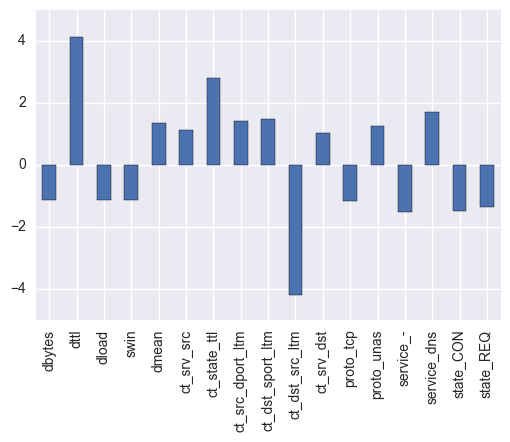

In [50]:
std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 
threshold = 1 
# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    
# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']

# now look at the weights
weights = pd.Series(trained_model_from_pipeline.coef_[0],index=df.columns)
temp_df = pd.DataFrame(weights)
temp_df = temp_df[(temp_df[0] > threshold) | (temp_df[0] < (-1 * threshold))]
weights = temp_df[0]
weights.plot(kind='bar')
plt.show()

**Use the weights from logistic regression to interpret the importance of different
features for each classification task. Explain your interpretation in detail. Why do you think
some variables are more important?**

The weights show us that there are certain features that greatly dominate the classification of a dependent variable. ct_dst_src_ltm and dttl both have weights larger than most other features. ct_state_ttl being the only other standout feature of the graph above for the kitchen sink model. This tells us that the destination time to live (dttl) and the count of the  (dst_src_ltm) influence whether an attack is occuring more than any other feature. These variables are more important because during an internet attack, the destination of the attack will excert much more of the attack than the source delivering the attack. 

   # Support Vector Machines

In [60]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

y_train2 = y_train.astype(float)
X_train_scaled2 = X_train_scaled.astype(float)

# train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object
#svm_clf.fit(X_train_scaled2, y_train2)  # train object
y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

('accuracy:', 0.93113081501275352)
[[6852  553]
 [ 581 8480]]


[[  1.76182752e-03   1.77290559e+00   2.49225827e+00  -3.76292246e+00
   -3.82703210e+00  -2.65244384e-01   4.18227103e-01   6.58995763e+00
    2.16436520e-02  -2.12108534e+00   1.83824902e+00   1.18387078e+00
   -2.62613969e-01  -3.16584603e-02  -1.55052476e-01   3.88933513e-01
   -9.18024384e-01   5.22911435e-03   2.42670908e-03  -1.21123359e+00
   -4.55245547e-01  -6.94479020e-01  -5.82816778e-02  -1.78552061e-02
    1.20518052e+00  -2.09285147e-02   1.68404852e-02   9.80689962e-01
    6.60288021e+00  -3.89114847e-01   2.84671783e+00   7.92760031e-01
   -7.72409574e+00   2.26971316e-02   2.23017281e-02  -2.92716596e-01
   -3.21476935e-01   1.84929188e+00  -1.72570291e-13   6.81266656e-02
    8.62987988e-02   8.46807986e-02   1.56287173e-01   4.91708996e-02
    6.64423627e-02  -1.78052018e-14   8.68101429e-02   6.97444784e-02
    7.91059299e-02   6.61616133e-02   4.78716302e-02   8.86067205e-02
    5.93621509e-02   7.06213756e-02   9.49849031e-02   9.52252960e-02
    6.98694633e-02  

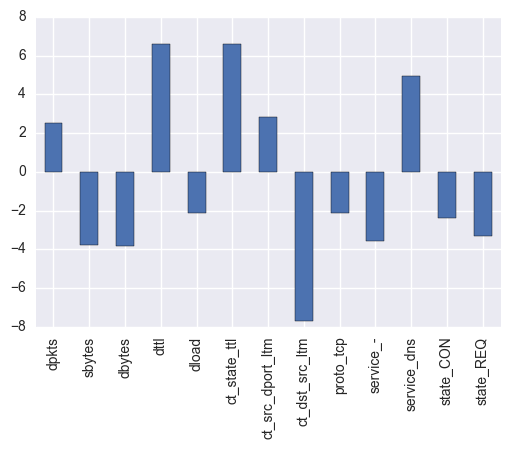

In [62]:
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df.columns)
temp_df = pd.DataFrame(weights)
threshold = 2  # Changed threshold as 1 didn't filter enough, too hard to read
temp_df = temp_df[(temp_df[0] > threshold) | (temp_df[0] < (-1 * threshold))]
weights = temp_df[0]
weights.plot(kind='bar')

E:\anaconda\envs\py27\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


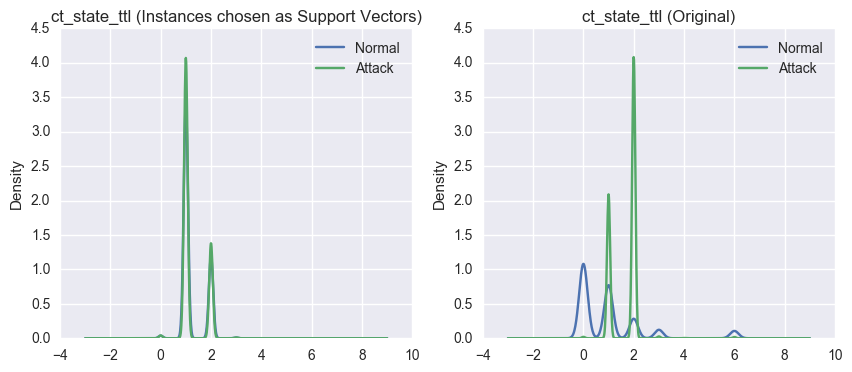

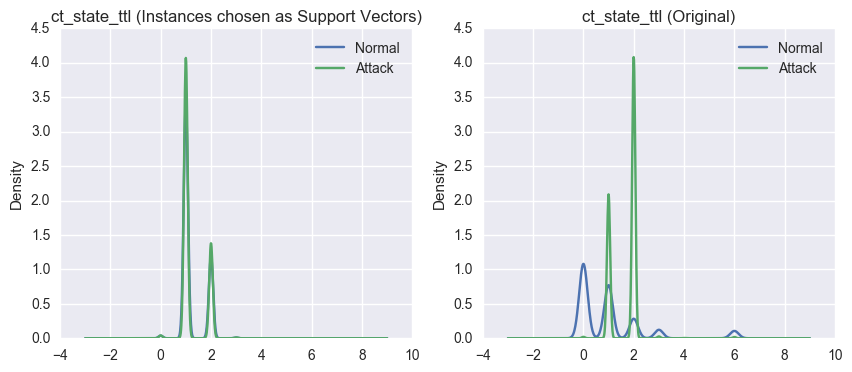

In [65]:
# make a dataframe of the training data
df_tested_on = df.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['label'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df['label'] = y # also add it back in for the original data

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['label'])
df_grouped = df.groupby(['label'])

# plot KDE of Different variables
#vars_to_plot = ['Age','Pclass','IsMale','FamilySize']
vars_to_plot = ['ct_state_ttl', 'ct_state_ttl']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Normal','Attack'])  # how do we not the correct order?
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Normal','Attack'])
    plt.title(v+' (Original)')

## SVM Analysis:
We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.

In [ ]:
# Five-Features Model SVM:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object_five: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

weights = pd.Series(svm_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')

In [ ]:
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['label'])
df_grouped = df.groupby(['label'])

# plot KDE of Different variables
vars_to_plot = ['sttl','ct_dst_sport_ltm','ct_src_dport_ltm','swin','dwin']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['No Attack','Attack'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['No Attack','Attack'])
    plt.title(v+' (Original)')

## Running logistic regression and vary some parameters

In [ ]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.cross_validation import cross_val_score
# ref": http://stackoverflow.com/questions/15707056/get-time-of-execution-of-a-block-of-code-in-python-2-7
import timeit

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
penaltyVals = ('l2', 'l1')
for penVal in penaltyVals:
    start_time = timeit.default_timer()
    lr_clf = LogisticRegression(penalty=penVal, C=1.0, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
    elapsed = timeit.default_timer() - start_time
    #print(accuracies)
    print "Penalty value (" + penVal + ") Average Accuracy across " + str(num_cv_iterations) + " shuffle split cross validation iterations = " + str(np.average(accuracies)) + " elasped time in seconds " + str(elapsed)
    

Run 1 (order:, l1, l2)
Penalty value (l1) Average Accuracy across 3 shuffle split cross validation iterations = 0.923316733471 elasped time in seconds 882.909233884
Penalty value (l2) Average Accuracy across 3 shuffle split cross validation iterations = 0.754949593101 elasped time in seconds 4.85387517498

Run 2( order: l2, l1)
Penalty value (l2) Average Accuracy across 3 shuffle split cross validation iterations = 0.752297663873 elasped time in seconds 5.01155646727
Penalty value (l1) Average Accuracy across 3 shuffle split cross validation iterations = 0.921555528564 elasped time in seconds 865.148999092

Note: not really sure if the research below really helps to explain our results. 

Reference for background on l1 and l2 for predition:
https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization
Typically ridge or ℓ2 penalties are much better for minimizing prediction error rather than ℓ1 penalties. The reason for this is that when two predictors are highly correlated, ℓ1 regularizer will simply pick one of the two predictors. In contrast, the ℓ2 regularizer will keep both of them and jointly shrink the corresponding coefficients a little bit. Thus, while the ℓ1 penalty can certainly reduce overfitting, you may also experience a loss in predictive power. 

ref: https://www.youtube.com/watch?v=sO4ZirJh9ds
Says L1 encourages some level of sparsity which makes model more efficient to store, compute and reveal which features are most important to the prediction. 

ref: https://www.youtube.com/watch?v=nmHNXsDPPFQ
Really good video on under, "just right" and overfitting (logistic regression)

Ref: http://scikit-learn.org/stable/modules/sgd.html
According to the reference above, Stochastic Gradient Descent is applicable to applicable to large scale and sparse machine learning problems where observations with more than 10^5 training examples and more than 10^5 features. In our case, we are not dealing with 82332 observations x 45  features from the raw original dataset.  In computing the model for logistic regression in the worst case runtime emperically run, it has taken about 866 seconds or 14 minutes.

## Advantages of each model for each classification task

Advantages of Logistic Regression are: 1) provides various ways to regularize a statistical model to prevent overfitting of the training model. 2) feature correlation is not as important. 3) provides a probabilistic interpretation. 4) allows for a model to be easily updated with new data. 5) can be used when the number of features is large and the training examples are small.

Advantages of Support Vector Machines are: 1) offers theoretical guarantees against overfitting the model. 2) can be used when the data is not linearly separable, using the appropriate kernel. 3) can be used when the number of features are smaller than the number of training examples, using the Gaussian or RBF kernel. 4) outperforms at identifying complex data boundaries.  5) generalizes well once the hyperplane is determined.

We can empiracally determine that the LR is much more efficient that the SVM models, with the LR models taking less than a minute to compute on our hardware, while the SVMs took more than 10 minutes each on a modern personal computer. 

We did run the Five-Feature model through all the kernels that were available and found that the RBF kernel provided the best accuracy for this model at 82.0%

In [ ]:
# Kernel = rbf for the Five-Feature model:
for train_indices, test_indices in cv_object_five: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

# train the model just as before / Kernal=rbf
svm_clf = SVC(kernel='rbf') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

In [ ]:
accuracy: 0.819821461104
[[6393  971]
 [1996 7107]]

SVMs for the different parameters and kernels for the Kitchen Sink Model:

In [ ]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC
# ref: http://scikit-learn.org/stable/modules/svm.html

# train the model just as before

kernelVals = ('linear', 'poly', 'rbf', 'sigmoid') 
degreeVals = (1, 2, 3, 4)  # Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
for kernelVal in kernelVals:
    for degreeVal in degreeVals:
        start_time = timeit.default_timer()
        svm_clf = SVC(C=0.5, kernel=kernelVal, degree=degreeVal, gamma='auto') # get object
        svm_clf.fit(X_train_scaled, y_train)  # train object
        #svm_clf.fit(X_train_scaled2, y_train2)  # train object
        y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

        acc = mt.accuracy_score(y_test,y_hat)
        conf = mt.confusion_matrix(y_test,y_hat)
        elapsed = timeit.default_timer() - start_time
        
        print('accuracy:', acc )
        print "kernel Vals (" + kernelVal + ") Degree Val (" + str(degreeVal) + ") Average Accuracy across " + str(num_cv_iterations) + " shuffle split cross validation iterations = " + str(acc) + " elasped time in seconds " + str(elapsed)

`('accuracy:', 0.93380298797522165)
kernel Vals (linear) Degree Val (1) Average Accuracy across 3 shuffle split cross validation iterations = 0.933802987975 elasped time in seconds 565.340272169
('accuracy:', 0.93380298797522165)
kernel Vals (linear) Degree Val (2) Average Accuracy across 3 shuffle split cross validation iterations = 0.933802987975 elasped time in seconds 563.470504869
('accuracy:', 0.93380298797522165)
kernel Vals (linear) Degree Val (3) Average Accuracy across 3 shuffle split cross validation iterations = 0.933802987975 elasped time in seconds 560.159730786
('accuracy:', 0.93380298797522165)
kernel Vals (linear) Degree Val (4) Average Accuracy across 3 shuffle split cross validation iterations = 0.933802987975 elasped time in seconds 563.94064991
('accuracy:', 0.89560306085266606)
kernel Vals (poly) Degree Val (1) Average Accuracy across 3 shuffle split cross validation iterations = 0.895603060853 elasped time in seconds 520.913972599
('accuracy:', 0.87720150613385162)
kernel Vals (poly) Degree Val (2) Average Accuracy across 3 shuffle split cross validation iterations = 0.877201506134 elasped time in seconds 626.838469766
('accuracy:', 0.86062188752581081)
kernel Vals (poly) Degree Val (3) Average Accuracy across 3 shuffle split cross validation iterations = 0.860621887526 elasped time in seconds 830.176852918
('accuracy:', 0.8328677274383578)
kernel Vals (poly) Degree Val (4) Average Accuracy across 3 shuffle split cross validation iterations = 0.832867727438 elasped time in seconds 1162.60127933
('accuracy:', 0.92025992955180369)
kernel Vals (rbf) Degree Val (1) Average Accuracy across 3 shuffle split cross validation iterations = 0.920259929552 elasped time in seconds 519.948282173
('accuracy:', 0.92025992955180369)
kernel Vals (rbf) Degree Val (2) Average Accuracy across 3 shuffle split cross validation iterations = 0.920259929552 elasped time in seconds 523.602242189
('accuracy:', 0.92025992955180369)
kernel Vals (rbf) Degree Val (3) Average Accuracy across 3 shuffle split cross validation iterations = 0.920259929552 elasped time in seconds 522.028495109
('accuracy:', 0.92025992955180369)
kernel Vals (rbf) Degree Val (4) Average Accuracy across 3 shuffle split cross validation iterations = 0.920259929552 elasped time in seconds 524.807356343
('accuracy:', 0.87076399854245112)
kernel Vals (sigmoid) Degree Val (1) Average Accuracy across 3 shuffle split cross validation iterations = 0.870763998542 elasped time in seconds 444.834268771
('accuracy:', 0.87076399854245112)
kernel Vals (sigmoid) Degree Val (2) Average Accuracy across 3 shuffle split cross validation iterations = 0.870763998542 elasped time in seconds 453.045675398
('accuracy:', 0.87076399854245112)
kernel Vals (sigmoid) Degree Val (3) Average Accuracy across 3 shuffle split cross validation iterations = 0.870763998542 elasped time in seconds 455.094115902
('accuracy:', 0.87076399854245112)
kernel Vals (sigmoid) Degree Val (4) Average Accuracy across 3 shuffle split cross validation iterations = 0.870763998542 elasped time in seconds 453.934751164`

### Analysis: most accurate combination of kernel was the linear kernel (93%) with second place 'rbf' with (92%) accuracy.